# Protected Areas

Visualizing % of Exclusive Economic Zones (EEZs) protected over time 

*Author: Rachel Thoms
<br>Created: 08 24 2021
<br>Environment: jupyterlab*

## Style

- Vega chart
- Chart type
- Value 

## Data

- Data: [ow_widget_territory](https://resourcewatch.carto.com/u/wri-rw/dataset/ow_widget_territory) (full dataset - [ocn_023_rw0_marine_protection](https://resourcewatch.carto.com/u/wri-rw/dataset/ocn_023_rw0_marine_protection_edit))
- Resource Watch: [explore page](https://resourcewatch.org/data/explore/)
- Source: [OECD](https://data.oecd.org/biodiver/protected-areas.htm)

## Preparation

### Aliasing and Inserting Data

#### Queries

not inserted into master table

### Vega

In [2]:
import json
from vega import Vega
from IPython.display import display

In [3]:
def Vega(spec):
    bundle = {}
    bundle['application/vnd.vega.v5+json'] = spec
    display(bundle, raw=True)

In [4]:
widget_width = 500
widget_height = 200

## Visualization

### Queries

#### Testing version

```gadm.geostore_prod ILIKE 'f4599aaeedacb9e6ddca177a93795e4c'``` used as stand-in for parameterized ```{{geostore_env}}='{{geostore_id}}'``` in production version

```sql
adm.gid_0, country, year AS date, value FROM 
(SELECT iso, country, year, value FROM ocn_023_rw0_marine_protection_edit 
UNION SELECT 'GLB' AS iso, 'Global' as country, year, value FROM ocn_023_rw0_marine_protection_edit 
WHERE iso='WLD' 
UNION SELECT 'GLB' AS iso, country, year, value FROM ocn_023_rw0_marine_protection_edit 
WHERE iso='ABNJ') AS data 
LEFT OUTER JOIN gadm36_0 gadm ON data.iso = gadm.gid_0 
WHERE gadm.geostore_prod = 'f4599aaeedacb9e6ddca177a93795e4c' 
ORDER BY date ASC, name_0 ASC
```

#### Parameterized version

```sql
SELECT gadm.gid_0, country, year AS date, value FROM 
(SELECT iso, country, year, value FROM ocn_023_rw0_marine_protection_edit 
UNION SELECT 'GLB' AS iso, 'Global' as country, year, value FROM ocn_023_rw0_marine_protection_edit 
WHERE iso='WLD' 
UNION SELECT 'GLB' AS iso, country, year, value FROM ocn_023_rw0_marine_protection_edit 
WHERE iso='ABNJ') AS data 
LEFT OUTER JOIN gadm36_0 gadm ON data.iso = gadm.gid_0 WHERE gadm.{{geostore_env}} = '{{geostore_id}}' 
ORDER BY date ASC, name_0 ASC
```

In [6]:
spec=json.loads("""{
  "$schema": "https://vega.github.io/schema/vega/v5.json",
  "width": 500,
  "height": 200,
  "padding": 5,
  "data": [
    {
      "name": "table",
      "url": "https://wri-rw.carto.com/api/v2/sql?q= SELECT gadm.gid_0, country, year AS date, value FROM (SELECT iso, country, year, value FROM ocn_023_rw0_marine_protection_edit UNION SELECT 'GLB' AS iso, 'Global' as country, year, value FROM ocn_023_rw0_marine_protection_edit WHERE iso='WLD' UNION SELECT 'GLB' AS iso, country, year, value FROM ocn_023_rw0_marine_protection_edit WHERE iso='ABNJ') AS data LEFT OUTER JOIN gadm36_0 gadm ON data.iso = gadm.gid_0 WHERE gadm.{{geostore_env}}= '{{geostore_id}}' ORDER BY date ASC, name_0 ASC",
      "format": {"type": "json", "property": "rows"}},
      {"name": "maximum",
    "source": "table",
    "transform": [{"type": "collect", "sort": {"field": "value","order": "descending"}}
  ]},
      {"name": "mpa",
      "source": "table",
      "transform": [ {
          "type":"formula",
          "expr": "'30%'",
          "as": "goal"
        },
        {
          "type":"formula",
          "expr": "datum.value/100",
          "as": "value"
        },
        {
          "type": "stack",
          "groupby": ["date"],
          "sort": {"field": "country"},
          "field": "value"
        },
        {"type": "formula",
        "expr": "datum.y0 + datum.y1",
        "as": "total"},
        {"type": "collect", "sort": {"field": ["date","country"],"order": ["ascending", "ascending"]}}
      ]
    },
    {
      "name": "highlightedPoint",
      "source": "mpa",
      "transform": [
        {
          "type": "filter",
          "expr": "(point_hover && point_hover.datum.date === datum.date) "
        }
      ]
    }],
  "signals": [
    {
      "name": "point_hover",
      "value": null,
      "on": [
        {"events": "@points_voronoi:mouseover", "update": "datum"},
        {"events": "@points_voronoi:mouseout", "update": "null"}
      ]
    },
    {"name": "gid", "update": "data('mpa')[0]['gid_0']"},
    {"name": "max", "update": "data('maximum')[0]['value']/100"}
  ],
  "scales": [
    {
      "name": "x",
      "type": "point",
      "range": "width",
      "domain": {"data": "mpa", "field": "date"}
    },
    {
      "name": "y",
      "type": "linear",
      "range": "height",
      "nice": true,
      "zero": true,
      "domain": {"data": "mpa", "field": "value"},
      "domainMax": {"signal": "gid === 'GLB' ? 0.30 : max < 0.80 ? max + 0.10 : 1"}
    },
    {
      "name": "colors",
      "type": "ordinal",
      "range": ["#84c0d0","#005c7e"],
      "domain": {"data": "mpa", "field": "country"}
    
    },
    {
      "name": "color",
      "type": "ordinal",
      "range": ["#005c7e"],
      "domain": {"data": "mpa", "field": "country"}
    }
  ],
  "axes": [
    {
      "orient": "bottom",
      "scale": "x",
      "labelBaseline": "middle",
      "labelOverlap": true,
      "labelFontSize": 10
    },
    {
      "orient": "left",
      "scale": "y",
      "labelBaseline": "middle",
      "labelAlign": "right",
      "labelPadding": 3,
      "grid": true,
      "gridOpacity": 0.1,
      "labelFontSize": 10,
      "format": "%"
    }
  ],
  "marks": [
    {
      "type": "group",
      "from": {"facet": {"name": "series", "data": "mpa", "groupby": "country"}},
      "marks": [
        {
          "type": "line",
          "from": {"data": "series"},
          "encode": {
            "enter": {
              "x": {"scale": "x", "field": "date"},
              "y": {"scale": "y", "field": "y0"},
              "stroke": {"value": "#84c0d0"},
              "strokeWidth": {"value": 2}
            },
            "update": {
              "interpolate": {"value": "monotone"},
              "strokeOpacity": {"value": 1}
            },
            "hover": {"strokeOpacity": {"value": 0.5}}
          }
        },
        {
          "type": "line",
          "from": {"data": "series"},
          "encode": {
            "enter": {
              "x": {"scale": "x", "field": "date"},
              "y": {"scale": "y", "field": "y1"},
              "stroke": {"value": "#005c7e"},
              "strokeWidth": {"value": 2}
            },
            "update": {
              "interpolate": {"value": "monotone"},
              "strokeOpacity": {"value": 1}
            }
          }
        },
        {
          "type": "area",
          "from": {"data": "series"},
          "encode": {
            "enter": {
              "x": {"scale": "x", "field": "date"},
              "y": {"scale": "y", "field": "y0"},
              "y2": {"scale": "y","field": "y1"},
              "fill": {"scale": {"signal": "(datum.gid_0=== 'GLB' ? 'colors' : 'color')"}, "field": "country"}
            },
            "update": {
              "interpolate": {"value": "monotone"},
              "fillOpacity": {"value": 0.8}
            },
            "hover": {"fillOpacity": {"value": 0.3}}
          }
        },
        {
          "name": "points",
          "type": "symbol",
          "from": {"data": "mpa"},
          "encode": {
            "update": {
              "x": {"scale": "x", "field": "date"},
              "y": {"scale": "y", "field": "y1"},
              "size": {"value": 6},
              "shape": {"value": "circle"},
              "strokeWidth": {"value": 2},
              "opacity": {"value": 1},
              "stroke": {"value": "transparent"},
              "fill": {"value": "transparent"}
            }
          }
        },
        {
          "name": "points_voronoi",
          "type": "path",
          "from": {"data": "points"},
          "encode": {
            "update": {
              "fill": {"value": "transparent"},
              "strokeWidth": {"value": 0.35},
              "stroke": {"value": "transparent"},
              "strokeOpacity": {"value": 0.2},
              "isVoronoi": {"value": true}
            }
          },
          "transform": [
            {
              "type": "voronoi",
              "x": "datum.x",
              "y": "datum.y",
              "extent": {"signal": "[[0, scale('y', max)],[width, height]]"}
            }
          ]
        },
        {
          "from": {"data": "highlightedPoint"},
          "type": "symbol",
          "interactive": false,
          "encode": {
            "update": {
              "x": {"scale": "x", "field": "date"},
              "y": {"scale": "y", "field": "y1"},
              "stroke": {"scale": {"signal": "(datum.gid_0=== 'GLB' ? 'colors' : 'color')"}, "field": "country"},
              "strokeWidth": {"value": 1},
              "fill": {"scale": {"signal": "(datum.gid_0=== 'GLB' ? 'colors' : 'color')"}, "field": "country"},
              "size": {"value": 150},
              "fillOpacity": {"value": 0.7}
            }
          }
        }
      ]
    },
        {
          "name": "line",
          "from": {"data": "mpa"},
          "type": "line",
          "zindex": 1,
          "encode": {
            "enter": {
              "x": {"scale": "x", "field": "date"},
              "y": {"scale": "y", "value": 0.3},
              "strokeOpacity": [{"test": "gid === 'GLB'", "value": 1 },{"value": 0}],
              "stroke": [{"test": "gid === 'GLB'", "value": "gold" },{"value": "transparent"}],
              "strokeWidth":{"value": 3},
              "strokeDash": {"value": [8, 4]}
            },
            "update":{
              "strokeOpacity":{"value": 1}
            },
          "hover":{
            "strokeOpacity":{"value": 0.5}
          }
          }
        }
  ],
    "interaction_config": [
    {
      "name": "tooltip",
      "config": {
        "fields": [
          {
            "column": "datum.country",
            "property": "Area",
            "type": "text",
            "format": ""
          },
          {
            "column": "datum.date",
            "property": "Year",
            "type": "text",
            "format": ""
          },
          {
            "column": "datum.value",
            "property": "Proportion Protected",
            "type": "number",
            "format": ".1%"
          },
          {
            "column": "goal",
            "property": "Post-2020 global biodiversity framework target",
            "type": "text",
            "format": ""
          }

        ]
      }
    }
  ]
}""")

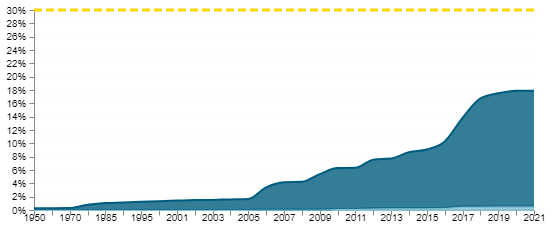

In [7]:
vega_view=dict(spec)
vega_view['data'][0]['url']= vega_view['data'][0]['url'].replace('{{geostore_env}}','geostore_prod')
vega_view['data'][0]['url'] = vega_view['data'][0]['url'].replace('{{geostore_id}}','fe855e0073d3a7c45ccd5f653841bb8d')
Vega(vega_view)

[Open the Chart in the Vega Editor](https://vega.github.io/editor/#/url/vega/N4IgJAzgxgFgpgWwIYgFwhgF0wBwqgegIDc4BzJAOjIEtMYBXAI0poHsDp5kTykSArJQBWENgDsQAGhAB3GgBN6aAQAZVM+DTJY0AJnUycSBQpriyKmQqSYUqANqhxSBHDQg7TADbuZDACdvDyxcfCJZAJoAWgDZSigkAMw2BLYEAiQcGhI9TgBHbwB+fIBeAAIAZQBRABlqgGEAFXKKBQRqRQB9DXKoNgZxTACATylykbgk8oBBSvKbTDhx4iRvBjhygDEAJQB5AFlygAoa+ubymjFx-sHhsYmpgJW1je39o7YocR69AGYunFVF1kFFxHAujgAmwllBMOwfnAzJhygBVAByAEk9uiqnVGi0AOQAcVqACFCbN5lc2OMSd42Ew1pSkBA+gMhqNxpMki91ptdodyl8fqp-oDZMDQeYIVCYXA4Qiuki6OUAOoACWqO2qlzEpUJatqABFKRjsbizgTyiTyZS5nraey7lzHrzyqt+e8hSLfgCgSCkjLIdDYfCJMrkeqtTrHQaZmT0QApQkASipC1sSHK9S2LT2qKa2vKSb2mNxbQQfwAbD1WiYEOUcZm7KwxOUKpXOgo65rtbqu7Qe6oOzbSRSmztjcWyQBNFubOYNcYuNx1pfSEAAMzYAWQmDQoEwIxw7nQogkm7lp+SIw80NkEBAAF9n1JnK4zyBkAAPGgIBgEE3MRAigL8vF8TdhiQcQIB3Pc0CcTwTy-fpvF8OFgN3A9UFALcaDgbwFA8T0Nk3XcFDgAIPEo6A4HEMwLBfZ8AF03w-NwPAQYwsNA8CkB8PxPACGC4N3IDHCPFCPHggDvBQGQ4B-KEaNsQDKFIuACAARnUTdWRI153HY5DTw8CA7CgABrTcyGhBgcCYO9HBARZ3BYmQxGSQ9twIoiPFuTk7zfXzCOI9BNJfd9TK-WSGHkzclJU9BFnUkYRwAahbNLtP0p90BSOxghM48zPQNCMIPTzsJ8-CwsQ1zbCEwL7hADyQAoqiGtZMCGPMSwZB6+jGMsNjWJM1cvxgbQYG8GalgUAAFNhzCqkAQICMCuJ4mRoNg2TEKksrfO8JZqMU5TqPQY4cBWoYuhgNhSACcoADJXvKW7Voep6qMoVKOjcjtSgqAH-qa9MXzY9qIG0FxvHypDJo8L77se57N0i1BxHi7wZEvSSQDgUghnykAAAFUcwCAumIXcJBW1AEAGCA4F+86QActzVMwQCotAYn6OpjxKbu6nafp8RGeZhhWYGNauaajwcfQqGJs-Dwh03RWlh5pBjkJbikDTBxVBYhxCSHHpCRY-mQGR9Bf21nBuZSrMDd-f9AJNs2Lc0m2oc8xJfERjivx-KDpPQKnNxEiwv3kJQYE3BR0iQcwfMWexvx20L-Ld3XX2ih2QDvXao5AObwSSWOYLIKa4HmzdxBoLbUGGDYZAALyotg0A75ZXLTjPcMauxtoUvPwpASKQtT5BzAOJAI9H2GyHhzXFGBipbQnIpylUSg-hHVByl-coAB5D4ADhHffz6yw+DHKU-cqLsOArYBkAifcvjoo8waxa7xwagAYmvgAFigKoBQqhNygPUAIKAAB2dy1hh6SFHlnCem46r5xAC1UYzFi4a3Kl-Xckd-4BEYkAmQcd65gMQSgtBQ8F6YNANgx2uc8HT0IcFVig0fxwFDh1KIQsPBMBhCkICQc1jh03PJJghEySskIjKLiigFCQRkIowiexnryRwP3AIndK4CUIlsCQmBKg0B7mgXSOjzHeEsUMDwMwohAJMruAirj0C+C3GtaAciPBlzMUo7wKjWZVy-AgTR2iwmERmHNde94m6OPCYtEwI00B-BkHZRQxjTH5IUHsYwUA6DOSfukixVibF2NQA4hJzirFuI8cEGQslbAeAAKSB2-EkKyIjSpfjsgMIxHToQSTwkgMCOEP7oFZmI3+Y9s5G1svZRyzkCEclakXfpARBmHRih4aJuDJmZyzOZKiBEnwhXov0SiPkhZdVHivUAQTILoAjh0vy09uYhWcu84OX5Qk8JCXAkKFloRWTPKALGIBwFQJgRCzyww2AwrVIoZQo8sZ6D2TrWFIBVpUVuvJXWOKjJcQZikcEUV1pophaUmZFSfJY20ns9GLz3kMrgEy8px5WWUtQIfAQr537HL8eoiZ6QLnjwWdc4RdL7lsEeaPZ5V1QBvPWsCjw3yp482MjIQF2rgnoFBb8kJb9UXQsJfChBqgkGoLpVC9FcBMVJ0FfyfQ+KXZK1HsSgIpK-VwqFd+alEhDX0ptXyllFKvUNI5ezHyLrGVlNjSG+NIqxUlQrkkKYZyZVYMufKpZSrxAPMJeqnyWqPnyJ+fVAukbjW1pCbgi1ZqUWlz0MmnVZq20NtLlak6wRV69veXDIB10wZW1UCDHe45KT70JGhXcEBKSn2XeQgIaY6VgrIS6fh-hfXktAAGoNJ6Z6huZlLGlkb8LoRjQKuNZFhWUGQYmjGo973eEfcarGh8-jZpIZxaOYtlnDPMiMBAkj2nbnOUWuVOcUB3PLSqwlBLq09tNSAPVe6x5Nqw580u-b8EjCHbDepGaX3VkhTALItrQ3lM2pBSFPL3XYqo2ePF+M01Ps4-Y1jNrPUvuEqJYwARxEhW-cJ8CccIDick2K4DX4qY0zptCKWNBKEqdsMnaVUyVkozA2WitPkMNfpoKrZ9smxN5tcYJ117Hk7WbQAB0V1rXUyY8HteTdmDwOdTcyvjl7M2UG40SiAAA1SWK0vPtxMXAEKKQv7wiMavCdI6QDAEJO4qYhJUBgzBnwuks4nj5cK2pQGTUpCEm6Z9UMCoFr5c6ZgY4FXeYdE0jVsL3S0zPmYkluTB1CYQYijFrTMgV5j3UnqrZYNQlKSWL48d69J0gAcKbcYZspAOETvQcYWgdCYGiIdrAAAqQ+qhtIsVtq+Ni0UtzwY4cWjAM1klYCRMtVadLRvrSgzBzcAaZnwlIGgLcaxWaKVQ6q0A5nNWEbrfqxtdLm29uI-W0j5GeUI+TRljwbXKvdh6HOscdpyhLpXT-ddNpKc7qk+27ZB7nVsaxc5-jCaflWaBaalbG8p2E5nST3ei6adbrXS-UX386cY94TsohkLbEMfjdpNQ9OH28b-UKw+76xX3fmZXKVcHC3PcQ2spLFdTnd3MJRFe2koembVUMLlOGcdfJI38pWALXfo5Cy+gDAXeUa9x6tzLQ5t6k73uUbSEvO0pqVyJsgX9iIB6c3FwDHmYXGlZGz33Z4HDXykBAsaR7XbcujUHlzHPPBsBSzQNLvO1vZeWhZaIBhn5kAZEybw5QmDsDMM9WGx5yiPc-LIXcVlyh2ACPXTA1PCTH16-1j9zu4+-ri1m3Xz4gA)

# Indicator

% of EEZ that is currently protected

## Country

```sql
SELECT value FROM ocn_023_rw0_marine_protection_edit 
INNER JOIN gadm36_0 gadm ON iso = gadm.gid_0 
WHERE year = 2018 
AND gadm.{{geostore_env}} ILIKE '{{geostore_id}}'
```

- ```description```: Proportion of the marine environment that is protected
- ```query```: [https://wri-rw.carto.com/api/v2/sql?q=SELECT ROUND(value) FROM ocn_023_rw0_marine_protection_edit INNER JOIN gadm36_0 gadm ON iso = gadm.gid_0 WHERE year = 2021 AND gadm.{{geostore_env}} ILIKE '{{geostore_id}}'](https://wri-rw.carto.com/api/v2/sql?q=SELECT%20ROUND(value)%20FROM%20ocn_023_rw0_marine_protection_edit%20INNER%20JOIN%20gadm36_0%20gadm%20ON%20iso%20=%20gadm.gid_0%20WHERE%20year%20=%202021%20AND%20gadm.gid_0%20ILIKE%20%27MEX%27)
- ```format```: ```.2f```
- ```unit```: ```%```


## World

In [ ]:
```sql
SELECT SUM(value) FROM ocn_023_rw0_marine_protection_edit  
WHERE year = 2021
AND iso IN ('ABNJ','WLD')
```

- ```description```: Proportion of the marine environment that is protected
- ```query```: [https://wri-rw.carto.com/api/v2/sql?q=SELECT ROUND(SUM(value)) FROM ocn_023_rw0_marine_protection_edit WHERE year = 20 AND iso IN ('ABNJ','WLD')](https://wri-rw.carto.com/api/v2/sql?q=SELECT%20ROUND(SUM(value))%20FROM%20ocn_023_rw0_marine_protection_edit%20WHERE%20year%20=%202021%20AND%20iso%20IN%20(%27ABNJ%27,%27WLD%27))
- ```unit```: ```%```


## RW Backoffice

- [back office](https://resourcewatch.org/admin/data/widgets/92e5286e-b40a-4a6f-a3e5-84ac9b49d459/edit?dataset=40c8d7b8-36b6-4f07-8941-cc61dc62fc12)
- parent dataset [ocn.023](https://resourcewatch.org/data/explore/40c8d7b8-36b6-4f07-8941-cc61dc62fc12) (unpublished)
- dataset id ```40c8d7b8-36b6-4f07-8941-cc61dc62fc12```
- widget id: ```92e5286e-b40a-4a6f-a3e5-84ac9b49d459```
- [api widget](https://api.resourcewatch.org/v1/widget/92e5286e-b40a-4a6f-a3e5-84ac9b49d459?env=production)